# Fitbit Data Analysis

This Jupyter notebook is designed to process and visualize raw Fitbit data. Fitbit devices are capable of tracking various types of health and activity metrics, which can be valuable for both casual users and researchers.


## Heart Rate Data Processing

### Step 1: Import Libraries

In [35]:
import os
import json
import pandas as pd
import re
import ipywidgets as widgets
from IPython.display import display

### Step 2: Define Function to Load and Summarize JSON Data

In [36]:
def load_and_summarize_json_files(folder_path,folder_path2):
    # Create a progress bar
    progress_bar = widgets.IntProgress(value=0, min=0, max=100, description='Processing:')
    display(progress_bar)
    progress_text = widgets.Label(value="Starting processing...")
    display(progress_text)
    summary_data = []
    pattern = re.compile(r'heart_rate-(\d{4}-\d{2}-\d{2}).json')
    pattern_csv = re.compile(r'Daily Heart Rate Variability Summary - (\d{4}-\d{2}-\d{2}).csv')
    count = 0
    total_files = len([f for f in os.listdir(folder_path) if pattern.match(f)])
    output_csv_path = './output/HeartRateProcessed.csv'

    # Check if the output CSV file exists
    if os.path.exists(output_csv_path):
        # If it does, load the data from it
        summary_data = pd.read_csv(output_csv_path).to_dict('records')
        # Find the most recent date in the data
        most_recent_date = max(record['date'] for record in summary_data)
    else:
        most_recent_date = None

    for filename in [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]:
        match = pattern.match(filename)
        if match and (most_recent_date is None or match.group(1) > most_recent_date):
            date = match.group(1)
            with open(f'{folder_path}/{filename}', 'r') as file:
                data = json.load(file)
                df = pd.DataFrame(data)
                df[['bpm', 'confidence']] = df['value'].apply(pd.Series)

                # Filter data to include only records with a confidence level of 2 or greater
                filtered_df = df[df['confidence'] >= 2]

                mean_bpm = round(filtered_df['bpm'].mean(), 2)
                max_bpm = round(filtered_df['bpm'].max(), 2)
                min_bpm = round(filtered_df['bpm'].min(), 2)
                
                 # Retrieve 'nremhr' value from the corresponding CSV file
                # Adjust the filename format based on the day of the month
                # Parse the date to get day, month and year, account for weird raw data format
                year, month, day = int(date[:4]), int(date[5:7]), int(date[8:])
                # Check if the day is the first day of the month
                if day == 1:
                    csv_filename = f"Daily Heart Rate Variability Summary - {year}-{month:02d}-.csv"
                else:
                    # Format the filename based on the day of the month
                    day = day - 1
                    if day < 10:
                        csv_filename = f"Daily Heart Rate Variability Summary - {year}-{month:02d}-({day}).csv"
                    else:
                        csv_filename = f"Daily Heart Rate Variability Summary - {year}-{month:02d}-({day}).csv"
                if csv_filename in os.listdir(folder_path2):
                    csv_df = pd.read_csv(f'{folder_path2}/{csv_filename}')
                    nremhr = csv_df['nremhr'].iloc[0] if 'nremhr' in csv_df.columns else None
                    rmssd = csv_df['rmssd'].iloc[0] if 'rmssd' in csv_df.columns else None
                else:
                    nremhr = None
                    rmssd = None

                summary_data.append({'date': date, 'mean_bpm': mean_bpm, 'max_bpm': max_bpm, 'min_bpm': min_bpm, 'nremhr': nremhr, 'rmssd': rmssd})
                # Update progress bar value to be the percentage of total finished
                
                progress_bar.value = (count / total_files) * 100
                # Update progress text with the last date processed
                progress_text.value = f"Last processed date: {date}"
                count += 1
                """ if count >= 150:  # Process only the first 15 matching JSON files
                    break  """
            
    return pd.DataFrame(summary_data)


### Step 3: Read and Consolidate HR Data

In [37]:


user_folder = '23_Dec'

folder_path = f'.\data\{user_folder}\Global Export Data'
folder_path2 = f'.\data\{user_folder}\Heart Rate Variability'
summary_data = load_and_summarize_json_files(folder_path,folder_path2)

# Convert the "date" column to a datetime object
summary_data['date'] = pd.to_datetime(summary_data['date'])
output_csv_path = './output/HeartRateProcessed.csv'
summary_data.to_csv(output_csv_path, index=False)
print(f"Summary data saved to {output_csv_path}")


IntProgress(value=0, description='Processing:')

Label(value='Starting processing...')

Summary data saved to ./output/HeartRateProcessed.csv


#### Process Respiratory rate & HRV details Data

In [34]:
import pandas as pd
import os
import re
import ipywidgets as widgets
from IPython.display import display

# Step 1: Scan the folder for filenames matching the patterns
folder_path = './data/23_dec/Heart Rate Variability'  # current directory
pattern_hr = re.compile(r'Heart Rate Variability Details - (\d{4}-\d{2}-(\d{2})).csv')
pattern_rr = re.compile(r'Daily Respiratory Rate Summary - (\d{4}-\d{2}-\d{2}).csv')
files_to_process_hr = [f for f in os.listdir(folder_path) if pattern_hr.match(f)]

consolidated_data = []

progress_bar2 = widgets.IntProgress(value=0, min=0, max=100, description='Processing:')
display(progress_bar2)
progress_text2 = widgets.Label(value="Starting processing...")
display(progress_text2)
count = 0
# Step 2: For each matching HR file, read the data and aggregate the required metrics for the day
for filename in files_to_process_hr:
    file_path = os.path.join(folder_path, filename)
    date = pattern_hr.match(filename).group(1)
    
    progress_bar2.value = (count / len(files_to_process_hr)) * 100
    progress_text2.value = f"Processing file {filename}..."
    
    # Read CSV data into a DataFrame for HR
    df_hr = pd.read_csv(file_path)
    
    # Calculate the required metrics for the day for HR
    min_rmssd = df_hr['rmssd'].min()
    max_rmssd = df_hr['rmssd'].max()
    avg_rmssd = round(df_hr['rmssd'].mean(),2)

    # Check for the corresponding Respiratory Rate file
    rr_filename = f"Daily Respiratory Rate Summary - {date}.csv"
    if rr_filename in os.listdir(folder_path):
        rr_file_path = os.path.join(folder_path, rr_filename)
        df_rr = pd.read_csv(rr_file_path)
        daily_respiratory_rate = df_rr['daily_respiratory_rate'].iloc[0]
    else:
        daily_respiratory_rate = None

    consolidated_data.append({'date': date, 'min_rmssd': min_rmssd, 'max_rmssd': max_rmssd, 'avg_rmssd': avg_rmssd, 'daily_respiratory_rate': daily_respiratory_rate})
    count += 1

# Step 3: Consolidate all the aggregated data into a new DataFrame
consolidated_df = pd.DataFrame(consolidated_data)



# Step 4: Save the consolidated DataFrame to an output file
output_file = './output/VariabilityRespiratoryProcessed.csv'
consolidated_df.to_csv(output_file, index=False)

progress_text2.value = 'processing complete: ' + output_file

IntProgress(value=0, description='Processing:')

Label(value='Starting processing...')

### Step 4: Visualizations

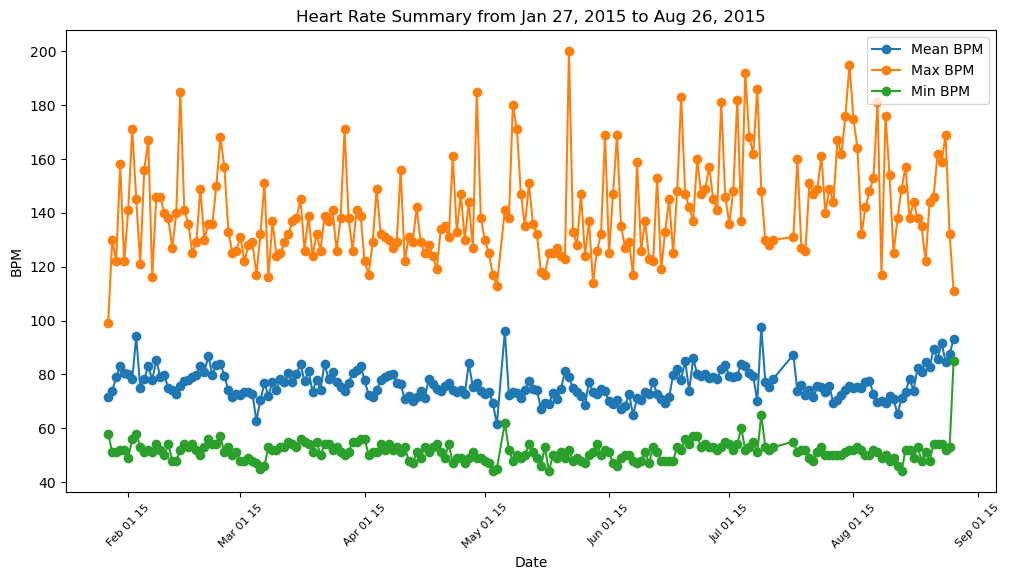

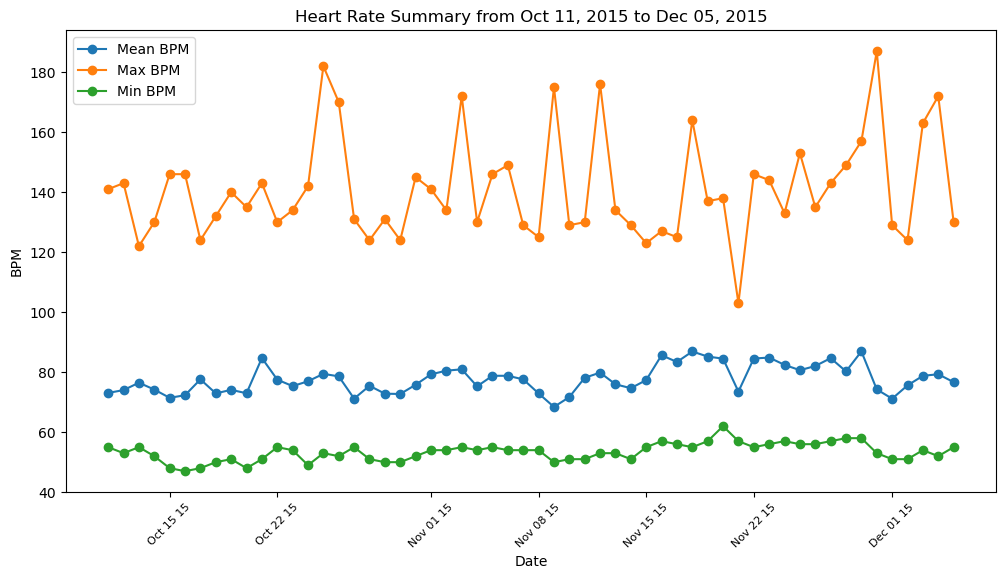

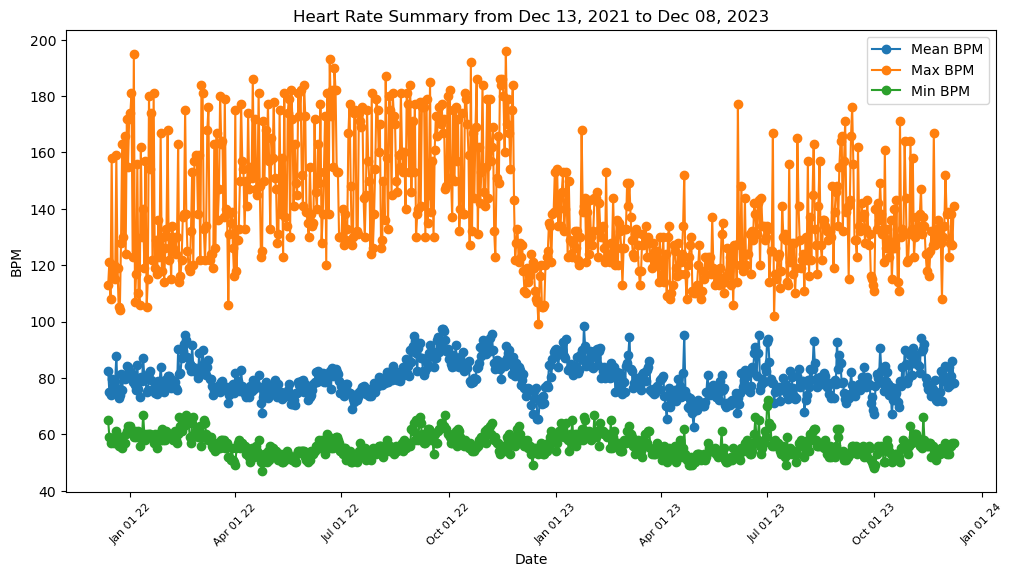

In [19]:

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Find the indices where there is a gap of more than 5 days
gaps = summary_data['date'].diff() > pd.Timedelta(days=5)
break_points = gaps[gaps].index.tolist()

# Add the start and end indices of the DataFrame
break_points = [0] + break_points + [len(summary_data)]


# Plot each contiguous segment in a separate graph
for i in range(len(break_points) - 1):
    segment = summary_data.iloc[break_points[i]:break_points[i + 1]]
    
    # Get the beginning and ending date for the segment
    start_date = segment['date'].iloc[0].strftime('%b %d, %Y')
    end_date = segment['date'].iloc[-1].strftime('%b %d, %Y')
    
    plt.figure(figsize=(12, 6))
    plt.plot(segment['date'], segment['mean_bpm'], label='Mean BPM', marker='o')
    plt.plot(segment['date'], segment['max_bpm'], label='Max BPM', marker='o')
    plt.plot(segment['date'], segment['min_bpm'], label='Min BPM', marker='o')
    plt.xlabel('Date')
    plt.ylabel('BPM')
    
    # Set the title to include the beginning and ending date for the segment
    plt.title(f'Heart Rate Summary from {start_date} to {end_date}')
    
    plt.legend()

    # Set the x-axis date format to be more concise
    date_format = mdates.DateFormatter('%b %d %y')  # Example: 'Jan 01 15'
    plt.gca().xaxis.set_major_formatter(date_format)

    # Rotate the date labels for better visibility
    plt.xticks(rotation=45, fontsize=8)  # Set small font size

    plt.show()


#### Plot Max BPM Distribution

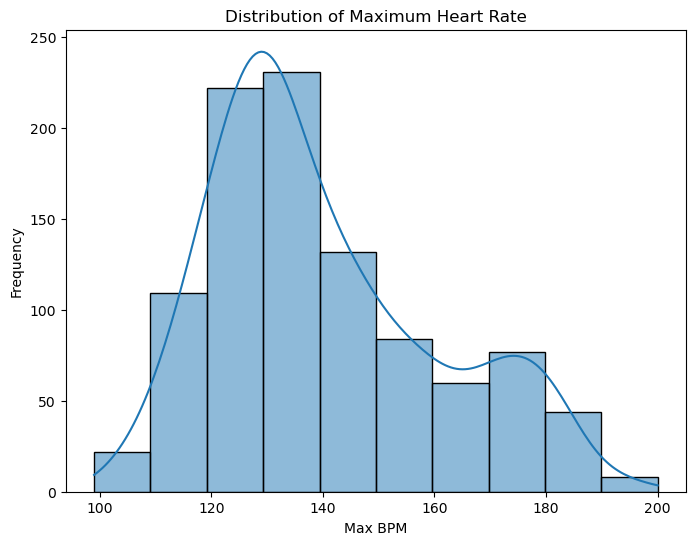

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(summary_data['max_bpm'], bins=10, kde=True)
plt.xlabel('Max BPM')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum Heart Rate')
plt.show()

#### Plot Min BPM Distribution

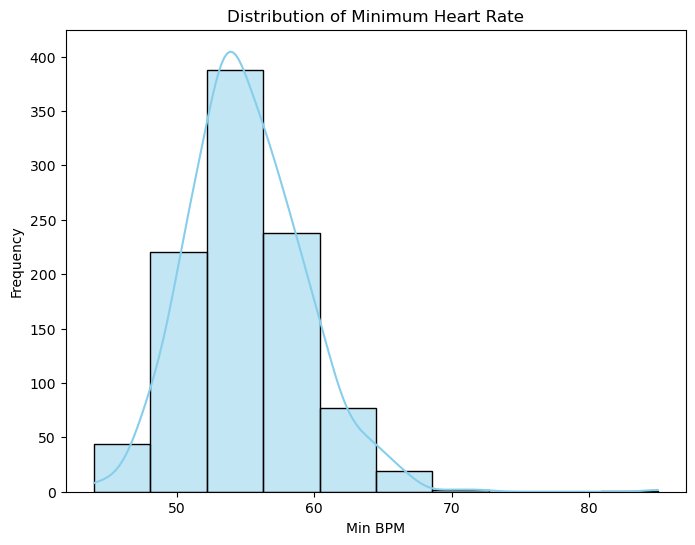

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(summary_data['min_bpm'], bins=10, kde=True, color='skyblue')
plt.xlabel('Min BPM')
plt.ylabel('Frequency')
plt.title('Distribution of Minimum Heart Rate')
plt.show()

### Plot Daily Rates


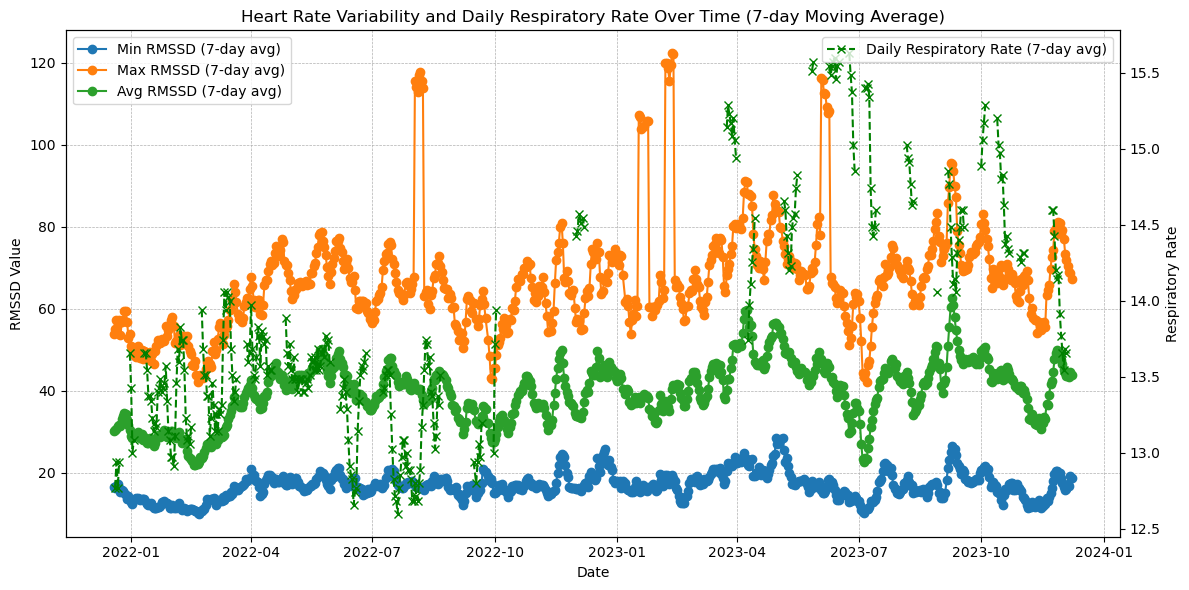

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the data from the CSV file into a DataFrame
file_path = './output/VariabilityRespiratoryProcessed.csv'
df = pd.read_csv(file_path)

# Step 2: Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Step 3: Calculate the moving average over a 7-day window for smoother plots
df['min_rmssd_avg'] = df['min_rmssd'].rolling(window=7).mean()
df['max_rmssd_avg'] = df['max_rmssd'].rolling(window=7).mean()
df['avg_rmssd_avg'] = df['avg_rmssd'].rolling(window=7).mean()
df['daily_respiratory_rate_avg'] = df['daily_respiratory_rate'].rolling(window=7).mean()

# Step 4: Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot RMSSD data on the primary y-axis
ax1.plot(df['date'], df['min_rmssd_avg'], label='Min RMSSD (7-day avg)', marker='o')
ax1.plot(df['date'][df['max_rmssd_avg'] <= 150], df['max_rmssd_avg'][df['max_rmssd_avg'] <= 150], label='Max RMSSD (7-day avg)', marker='o')
ax1.plot(df['date'], df['avg_rmssd_avg'], label='Avg RMSSD (7-day avg)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('RMSSD Value')
ax1.legend(loc='upper left')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a secondary y-axis for the daily_respiratory_rate
ax2 = ax1.twinx()
ax2.plot(df['date'], df['daily_respiratory_rate_avg'], label='Daily Respiratory Rate (7-day avg)', linestyle='--', marker='x', color='green')
ax2.set_ylabel('Respiratory Rate')
ax2.legend(loc='upper right')

plt.title('Heart Rate Variability and Daily Respiratory Rate Over Time (7-day Moving Average)')
plt.tight_layout()

# Show the plot
plt.show()


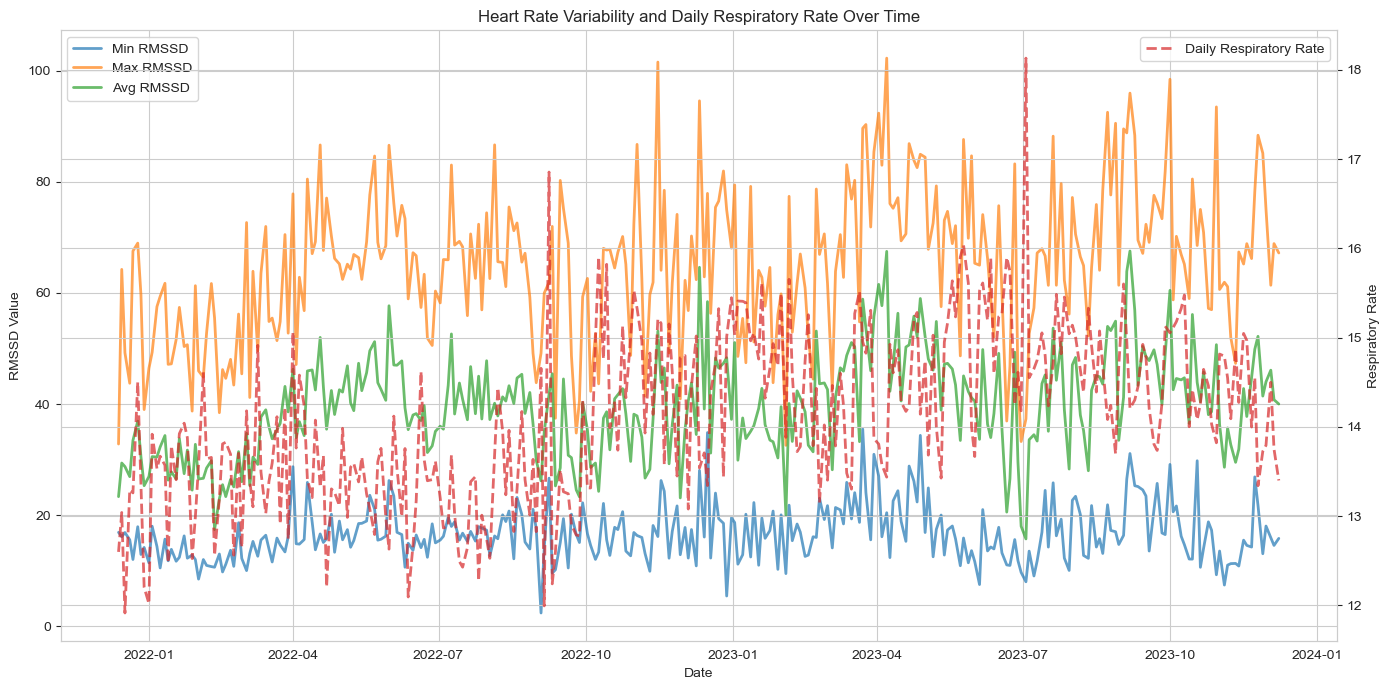

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline

# Step 1: Read the data from the CSV file into a DataFrame
file_path = './output/VariabilityRespiratoryProcessed.csv'
df = pd.read_csv(file_path)

# Drop rows with NaN values in columns other than 'daily_respiratory_rate'
df.dropna(subset=['min_rmssd', 'max_rmssd', 'avg_rmssd'], inplace=True)

# Step 2: Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Convert dates to ordinal numbers for interpolation
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Set the seaborn style
sns.set_style("whitegrid")

# Step 3: Plot the data
fig, ax1 = plt.subplots(figsize=(14, 7))

# Smoothing the lines using spline interpolation
xnew = np.linspace(df['date_ordinal'].min(), df['date_ordinal'].max(), 300)

# Plot RMSSD data on the primary y-axis
spl_min = make_interp_spline(df['date_ordinal'], df['min_rmssd'], k=3)
spl_max = make_interp_spline(df['date_ordinal'][df['max_rmssd'] <= 150], df['max_rmssd'][df['max_rmssd'] <= 150], k=3)
spl_avg = make_interp_spline(df['date_ordinal'], df['avg_rmssd'], k=3)

# Convert xnew (ordinal dates) back to datetime for plotting
xnew_dates = [pd.Timestamp.fromordinal(int(i)) for i in xnew]

ax1.plot(xnew_dates, spl_min(xnew), label='Min RMSSD', color='#1f77b4', linewidth=2, alpha=0.7)
ax1.plot(xnew_dates, spl_max(xnew), label='Max RMSSD', color='#ff7f0e', linewidth=2, alpha=0.7)
ax1.plot(xnew_dates, spl_avg(xnew), label='Avg RMSSD', color='#2ca02c', linewidth=2, alpha=0.7)

ax1.set_xlabel('Date')
ax1.set_ylabel('RMSSD Value')
ax1.legend(loc='upper left')

# Create a secondary y-axis for the daily_respiratory_rate if the column exists
if 'daily_respiratory_rate' in df.columns:
    # Handle NaN values for 'daily_respiratory_rate' by forward filling
    df['daily_respiratory_rate'].fillna(method='ffill', inplace=True)
    df['daily_respiratory_rate'].fillna(method='bfill', inplace=True)  # Backward fill

# If there are still NaN values, drop those rows
    df.dropna(subset=['daily_respiratory_rate'], inplace=True)

    
    ax2 = ax1.twinx()
    spl_rr = make_interp_spline(df['date_ordinal'], df['daily_respiratory_rate'], k=3)
    ax2.plot(xnew_dates, spl_rr(xnew), label='Daily Respiratory Rate', linestyle='--', color='#d62728', linewidth=2, alpha=0.7)
    ax2.set_ylabel('Respiratory Rate')
    ax2.legend(loc='upper right')

plt.title('Heart Rate Variability and Daily Respiratory Rate Over Time')
plt.tight_layout()

# Show the plot
plt.show()



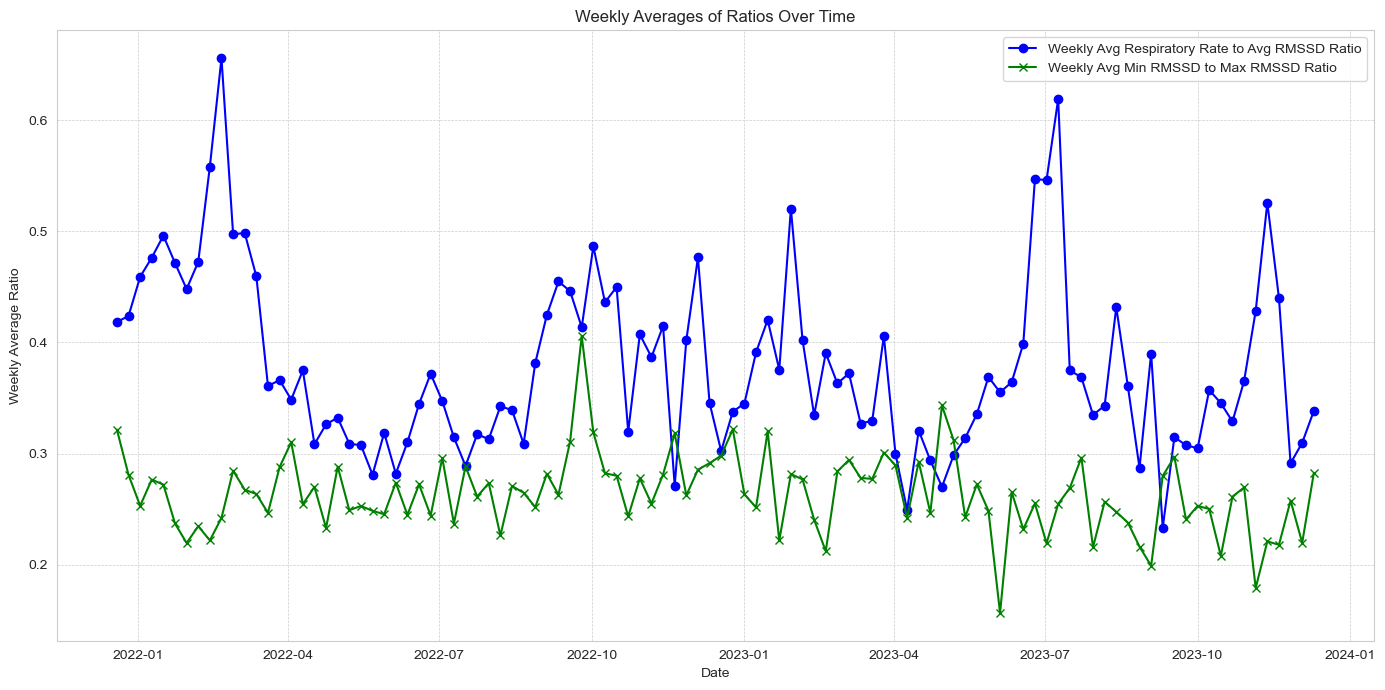

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
file_path = './output/VariabilityRespiratoryProcessed.csv'
df = pd.read_csv(file_path)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Calculate the ratios
# Handle division by zero by replacing any zero values with a small number
eps = 1e-10
df['respiratory_to_avg_rmssd'] = df['daily_respiratory_rate'] / (df['avg_rmssd'] + eps)
df['min_to_max_rmssd'] = df['min_rmssd'] / (df['max_rmssd'] + eps)

# Compute weekly averages
weekly_avg = df.resample('W').mean()

# Set the seaborn style for better visualization
sns.set_style("whitegrid")

# Plot the data
plt.figure(figsize=(14, 7))

# Plot weekly average ratio of respiratory rate to avg RMSSD
plt.plot(weekly_avg.index, weekly_avg['respiratory_to_avg_rmssd'], label='Weekly Avg Respiratory Rate to Avg RMSSD Ratio', marker='o', color='blue')

# Plot weekly average ratio of min RMSSD to max RMSSD
plt.plot(weekly_avg.index, weekly_avg['min_to_max_rmssd'], label='Weekly Avg Min RMSSD to Max RMSSD Ratio', marker='x', color='green')

# Set labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Weekly Average Ratio')
plt.title('Weekly Averages of Ratios Over Time')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


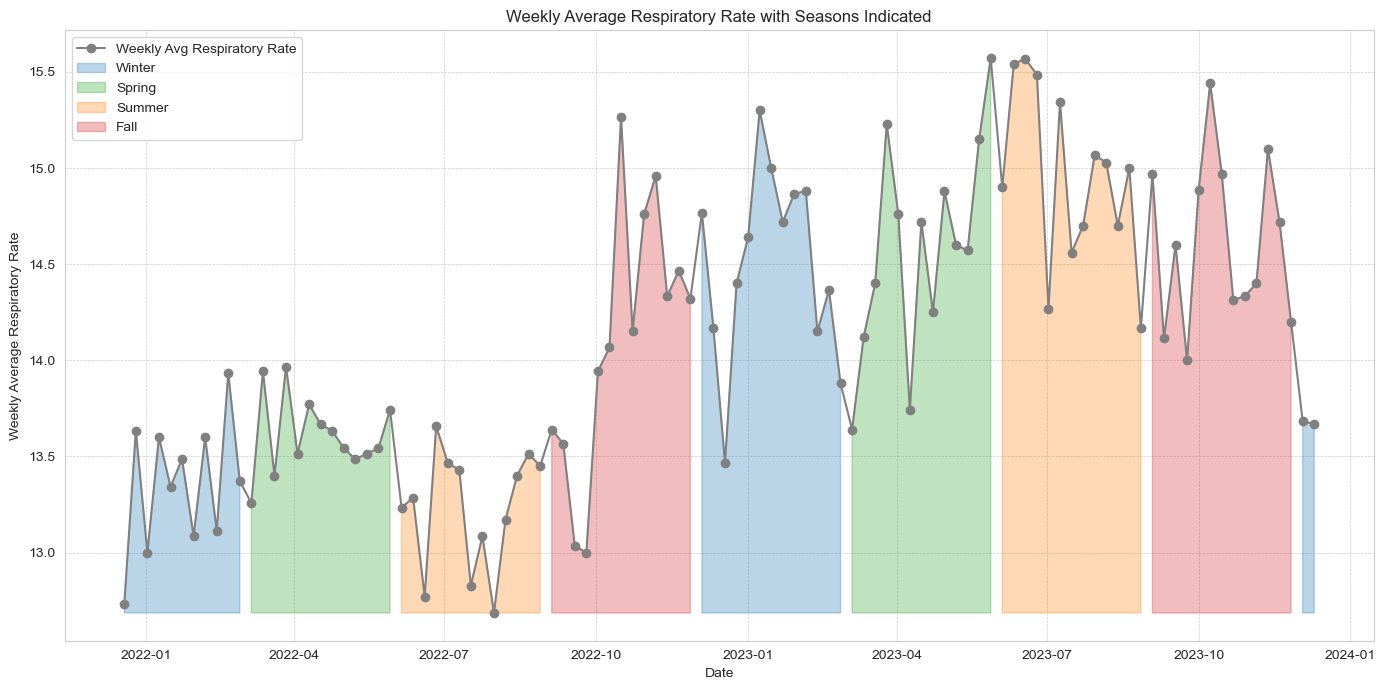

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
file_path = './output/VariabilityRespiratoryProcessed.csv'
df = pd.read_csv(file_path)

# Convert 'date' column to datetime format and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Compute weekly average respiratory rate
weekly_avg = df['daily_respiratory_rate'].resample('W').mean()

# Define a function to determine the season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Set the seaborn style for better visualization
sns.set_style("whitegrid")

# Plot the data
plt.figure(figsize=(14, 7))

# Plot the continuous line for weekly average respiratory rate
plt.plot(weekly_avg.index, weekly_avg, color='gray', marker='o', label='Weekly Avg Respiratory Rate')

# Color regions for each season
for season, color in zip(['Winter', 'Spring', 'Summer', 'Fall'], ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']):
    plt.fill_between(weekly_avg.index, weekly_avg.min(), weekly_avg, where=weekly_avg.index.month.isin([12, 1, 2]) if season == 'Winter' else
                    weekly_avg.index.month.isin([3, 4, 5]) if season == 'Spring' else
                    weekly_avg.index.month.isin([6, 7, 8]) if season == 'Summer' else
                    weekly_avg.index.month.isin([9, 10, 11]), color=color, alpha=0.3, label=season)

# Set labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Weekly Average Respiratory Rate')
plt.title('Weekly Average Respiratory Rate with Seasons Indicated')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()
